In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir('/content/drive/MyDrive/ml4qs/')

In [3]:
!pip install optuna
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import optuna

In [5]:
# Load the dataset
full_data = pd.read_parquet("full_dataset.parquet.gzip")

In [6]:
# Split the dataset into training and testing sets
random.seed(51)
testing_categories = [1, 2, 3, 4, 5, 6]
random.shuffle(testing_categories)

testing_set = [f"{platform}{number}" for platform, number in zip(full_data["SM_platform"].unique(), testing_categories)]
testing_df = full_data[full_data["source_name"].isin(testing_set)]
training_df = full_data[~full_data["source_name"].isin(testing_set)]

In [7]:
# Only select standardized columns
columns_to_select = [col for col in full_data.columns if 'zscore' in col] + ["SM_platform", "index"] + [col for col in
                                                                                                        full_data.columns
                                                                                                        if 'pc' in col]
training_df = training_df.loc[:, columns_to_select]
testing_df = testing_df.loc[:, columns_to_select]

In [13]:
# Separate features and target
X_train = training_df.drop(columns=["SM_platform"])
y_train = training_df["SM_platform"]
X_test = testing_df.drop(columns=["SM_platform"])
y_test = testing_df["SM_platform"]

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# # Normalize features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# reshape data for LSTM (samples, time_steps, features)
X_train = np.expand_dims(X_train.values, axis=2)
X_test = np.expand_dims(X_test.values, axis=2)

In [10]:
# Create sequences for LSTM
def create_sequences(data, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)


sequence_length = 10  # Example sequence length
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_encoded, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_encoded, sequence_length)

In [14]:
# Define the LSTM model
def create_model(trial):
    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units_1', 32, 128), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(trial.suggest_float('dropout_1', 0.2, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units_2', 16, 64)))
    model.add(Dropout(trial.suggest_float('dropout_2', 0.2, 0.5)))
    model.add(Dense(units=trial.suggest_int('dense_units', 32, 128), activation='relu'))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-2)),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
def objective(trial):
    model = create_model(trial)
    history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),
                        epochs=10, batch_size=trial.suggest_int('batch_size', 32, 128), verbose=0)

    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(y_test_encoded, y_pred)

    return accuracy

default training

In [14]:
# Define the LSTM model with default hyperparameters
def create_default_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
# Train the model with default hyperparameters
default_model = create_model()
history = default_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
4425/4425 [==============================] - 31s 6ms/step - loss: 0.0270 - accuracy: 0.9921 - val_loss: 11.9349 - val_accuracy: 0.0529
Epoch 2/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0065 - accuracy: 0.9982 - val_loss: 13.8987 - val_accuracy: 0.0293
Epoch 3/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 18.6766 - val_accuracy: 0.0426
Epoch 4/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 22.0848 - val_accuracy: 0.0117
Epoch 5/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 27.8058 - val_accuracy: 0.0282
Epoch 6/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 30.3497 - val_accuracy: 0.0218
Epoch 7/50
4425/4425 [==============================] - 25s 6ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 31.3043 -

In [16]:
# Evaluate the model
test_loss, test_accuracy = default_model.evaluate(X_test_seq, y_test_seq)
print(f'Test Accuracy: {test_accuracy:.4f}')

1118/1118 [==============================] - 3s 3ms/step - loss: 15.5960 - accuracy: 0.5352
Test Accuracy: 0.5352


In [17]:
# Predict and generate confusion matrix
y_pred = default_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)

1118/1118 [==============================] - 3s 2ms/step


In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_seq, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5985    1    0    0    0    0]
 [   9 5942    0    0    0    0]
 [   1 5951    3    0    0    0]
 [   0    7    0 5947    1    0]
 [   0    0    1 4695 1259    0]
 [   0    0 5952    3    0    0]]


In [19]:
# Classification Report
class_report = classification_report(y_test_seq, y_pred_classes, target_names=label_encoder.classes_)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          FB       1.00      1.00      1.00      5986
       Insta       0.50      1.00      0.67      5951
         Red       0.00      0.00      0.00      5955
      Reddit       0.56      1.00      0.72      5955
      TikTok       1.00      0.21      0.35      5955
           X       0.00      0.00      0.00      5955

    accuracy                           0.54     35757
   macro avg       0.51      0.53      0.46     35757
weighted avg       0.51      0.54      0.46     35757



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


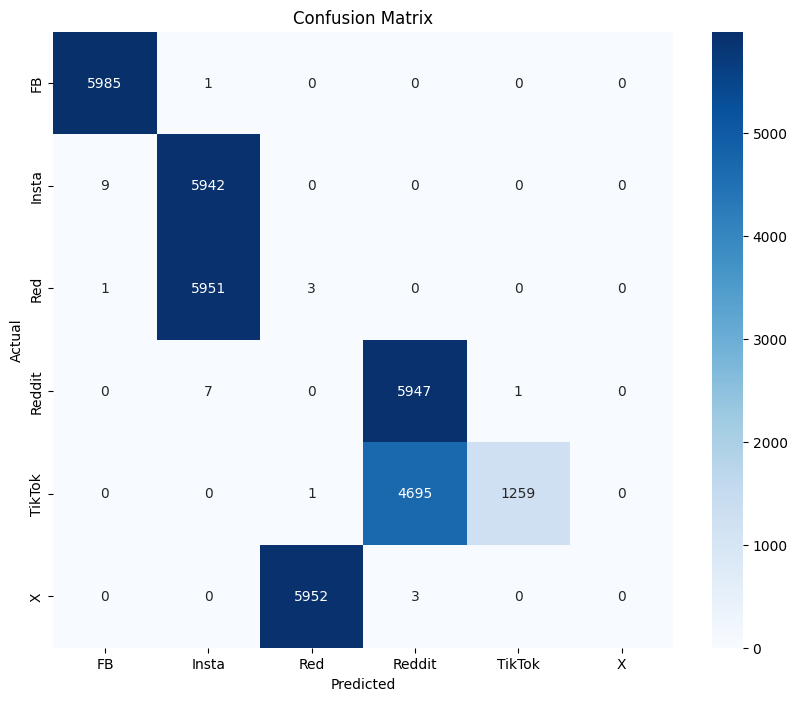

In [20]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

hyperparameter tuning with optuna

In [16]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-06-17 13:00:31,701] A new study created in memory with name: no-name-8321ffe3-3378-4a55-b466-86f5f9d1cd2d


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 13:06:06,341] Trial 0 finished with value: 0.6713730533732212 and parameters: {'units_1': 71, 'dropout_1': 0.49022053218146133, 'units_2': 37, 'dropout_2': 0.46368134615056555, 'dense_units': 102, 'learning_rate': 0.0038394144414305355, 'batch_size': 46}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 5s 3ms/step


[I 2024-06-17 13:11:58,451] Trial 1 finished with value: 0.6296306651382559 and parameters: {'units_1': 42, 'dropout_1': 0.24099796956805322, 'units_2': 61, 'dropout_2': 0.29177571745437514, 'dense_units': 62, 'learning_rate': 0.0017002458726699025, 'batch_size': 42}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 13:18:59,044] Trial 2 finished with value: 0.626527245785221 and parameters: {'units_1': 53, 'dropout_1': 0.46298693043266376, 'units_2': 56, 'dropout_2': 0.4143623030508512, 'dense_units': 53, 'learning_rate': 0.006320556546461697, 'batch_size': 35}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 13:26:24,781] Trial 3 finished with value: 0.5860430005312159 and parameters: {'units_1': 84, 'dropout_1': 0.266337303262814, 'units_2': 21, 'dropout_2': 0.30139164155346443, 'dense_units': 100, 'learning_rate': 0.009117335528683698, 'batch_size': 33}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 5s 4ms/step


[I 2024-06-17 13:29:40,276] Trial 4 finished with value: 0.629518830206615 and parameters: {'units_1': 40, 'dropout_1': 0.436757505237221, 'units_2': 39, 'dropout_2': 0.4482689604888783, 'dense_units': 78, 'learning_rate': 0.004055366333979134, 'batch_size': 79}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 5s 4ms/step


[I 2024-06-17 13:34:07,648] Trial 5 finished with value: 0.6132468476528644 and parameters: {'units_1': 91, 'dropout_1': 0.2271893012592324, 'units_2': 41, 'dropout_2': 0.22064441941072377, 'dense_units': 56, 'learning_rate': 0.002544011666274773, 'batch_size': 58}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 5s 4ms/step


[I 2024-06-17 13:37:14,047] Trial 6 finished with value: 0.6096960885732658 and parameters: {'units_1': 57, 'dropout_1': 0.2811812075396108, 'units_2': 27, 'dropout_2': 0.2026841543122045, 'dense_units': 45, 'learning_rate': 0.0002463268543210356, 'batch_size': 84}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 13:40:19,393] Trial 7 finished with value: 0.6179439147817821 and parameters: {'units_1': 57, 'dropout_1': 0.21028976234409213, 'units_2': 30, 'dropout_2': 0.22044267451784177, 'dense_units': 114, 'learning_rate': 0.004829434418260175, 'batch_size': 83}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 13:43:25,259] Trial 8 finished with value: 0.6026225291469791 and parameters: {'units_1': 88, 'dropout_1': 0.4670691877109649, 'units_2': 41, 'dropout_2': 0.44367398635535815, 'dense_units': 125, 'learning_rate': 0.0009915023836769706, 'batch_size': 86}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 5s 4ms/step


[I 2024-06-17 13:46:14,128] Trial 9 finished with value: 0.6436100315933682 and parameters: {'units_1': 94, 'dropout_1': 0.49033048962583725, 'units_2': 30, 'dropout_2': 0.4875091531011966, 'dense_units': 124, 'learning_rate': 0.00445722648280751, 'batch_size': 104}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 13:50:54,397] Trial 10 finished with value: 0.6111779014175077 and parameters: {'units_1': 122, 'dropout_1': 0.365464821657574, 'units_2': 52, 'dropout_2': 0.3725093399238344, 'dense_units': 94, 'learning_rate': 0.007397082412704859, 'batch_size': 57}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 5s 3ms/step


[I 2024-06-17 13:53:01,532] Trial 11 finished with value: 0.6699751167277099 and parameters: {'units_1': 107, 'dropout_1': 0.49898893457704924, 'units_2': 33, 'dropout_2': 0.48595465537798294, 'dense_units': 127, 'learning_rate': 0.002934422306945119, 'batch_size': 127}. Best is trial 0 with value: 0.6713730533732212.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 13:55:21,698] Trial 12 finished with value: 0.689294601168675 and parameters: {'units_1': 115, 'dropout_1': 0.40829908810704535, 'units_2': 47, 'dropout_2': 0.48694322072166685, 'dense_units': 104, 'learning_rate': 0.0030802433675626998, 'batch_size': 122}. Best is trial 12 with value: 0.689294601168675.


1118/1118 [==============================] - 5s 4ms/step


[I 2024-06-17 13:57:33,413] Trial 13 finished with value: 0.632007157435625 and parameters: {'units_1': 71, 'dropout_1': 0.3879795083113973, 'units_2': 47, 'dropout_2': 0.39123069466826993, 'dense_units': 98, 'learning_rate': 0.006226957033641388, 'batch_size': 128}. Best is trial 12 with value: 0.689294601168675.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 13:59:55,177] Trial 14 finished with value: 0.6117929935415327 and parameters: {'units_1': 127, 'dropout_1': 0.40975995095442275, 'units_2': 48, 'dropout_2': 0.44842344000580225, 'dense_units': 81, 'learning_rate': 0.003140508868993616, 'batch_size': 110}. Best is trial 12 with value: 0.689294601168675.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 14:03:44,451] Trial 15 finished with value: 0.6359772975088769 and parameters: {'units_1': 74, 'dropout_1': 0.3287797043802874, 'units_2': 64, 'dropout_2': 0.4998510905807287, 'dense_units': 109, 'learning_rate': 0.005568652495682769, 'batch_size': 61}. Best is trial 12 with value: 0.689294601168675.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 14:06:20,382] Trial 16 finished with value: 0.5968071127016523 and parameters: {'units_1': 107, 'dropout_1': 0.32808525243559333, 'units_2': 37, 'dropout_2': 0.333386166277575, 'dense_units': 83, 'learning_rate': 0.0036651211758774237, 'batch_size': 103}. Best is trial 12 with value: 0.689294601168675.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 14:10:02,970] Trial 17 finished with value: 0.6045516817177845 and parameters: {'units_1': 116, 'dropout_1': 0.4258951689463639, 'units_2': 20, 'dropout_2': 0.4154762756827699, 'dense_units': 113, 'learning_rate': 0.001937509020917157, 'batch_size': 71}. Best is trial 12 with value: 0.689294601168675.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 14:14:56,736] Trial 18 finished with value: 0.635613833981044 and parameters: {'units_1': 103, 'dropout_1': 0.4530764358854303, 'units_2': 45, 'dropout_2': 0.4653781543682287, 'dense_units': 90, 'learning_rate': 0.008463037881235586, 'batch_size': 47}. Best is trial 12 with value: 0.689294601168675.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 14:17:31,733] Trial 19 finished with value: 0.576704783739201 and parameters: {'units_1': 68, 'dropout_1': 0.39351181885608044, 'units_2': 54, 'dropout_2': 0.35267998503066045, 'dense_units': 72, 'learning_rate': 0.005548789465412736, 'batch_size': 94}. Best is trial 12 with value: 0.689294601168675.


In [17]:
# Best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial.value}")
print(f"Best hyperparameters: {best_trial.params}")

# Plot optimization history
optuna.visualization.plot_optimization_history(study)
plt.show()

Best trial: 0.689294601168675
Best hyperparameters: {'units_1': 115, 'dropout_1': 0.40829908810704535, 'units_2': 47, 'dropout_2': 0.48694322072166685, 'dense_units': 104, 'learning_rate': 0.0030802433675626998, 'batch_size': 122}


In [18]:
# Train the best model with the optimal hyperparameters
best_model = create_model(optuna.trial.FixedTrial(best_trial.params))
history = best_model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=10, batch_size=best_trial.params['batch_size'], verbose=1)


Epoch 1/10
1451/1451 [==============================] - 18s 10ms/step - loss: 0.3138 - accuracy: 0.8740 - val_loss: 2.3098 - val_accuracy: 0.5913
Epoch 2/10
1451/1451 [==============================] - 14s 9ms/step - loss: 0.1247 - accuracy: 0.9521 - val_loss: 2.7780 - val_accuracy: 0.5775
Epoch 3/10
1451/1451 [==============================] - 14s 9ms/step - loss: 0.0905 - accuracy: 0.9671 - val_loss: 2.9861 - val_accuracy: 0.6039
Epoch 4/10
1451/1451 [==============================] - 13s 9ms/step - loss: 0.0762 - accuracy: 0.9738 - val_loss: 2.0088 - val_accuracy: 0.6763
Epoch 5/10
1451/1451 [==============================] - 13s 9ms/step - loss: 0.0637 - accuracy: 0.9780 - val_loss: 2.1452 - val_accuracy: 0.6517
Epoch 6/10
1451/1451 [==============================] - 13s 9ms/step - loss: 0.0606 - accuracy: 0.9784 - val_loss: 3.3597 - val_accuracy: 0.6190
Epoch 7/10
1451/1451 [==============================] - 13s 9ms/step - loss: 0.0519 - accuracy: 0.9817 - val_loss: 3.2638 - val_a

In [19]:
# Evaluate the best model
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

1118/1118 [==============================] - 4s 3ms/step


In [20]:
# Performance report
print("Performance with Tuned Hyperparameters:")
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels)}")
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))

Performance with Tuned Hyperparameters:
Accuracy: 0.6614197444571812
Classification Report:
              precision    recall  f1-score   support

          FB       0.97      0.98      0.97      5996
       Insta       0.50      1.00      0.67      5951
         Red       0.00      0.00      0.00      5955
      Reddit       0.54      1.00      0.70      5955
      TikTok       0.98      0.16      0.27      5955
           X       0.98      0.83      0.90      5955

    accuracy                           0.66     35767
   macro avg       0.66      0.66      0.59     35767
weighted avg       0.66      0.66      0.59     35767

Confusion Matrix:
[[5857    6   54    0    0   79]
 [   4 5939    1    0    0    7]
 [   5 5918    1    2   13   16]
 [   0    0    0 5953    2    0]
 [   0   22    1 4983  949    0]
 [ 193    0  802    0    2 4958]]


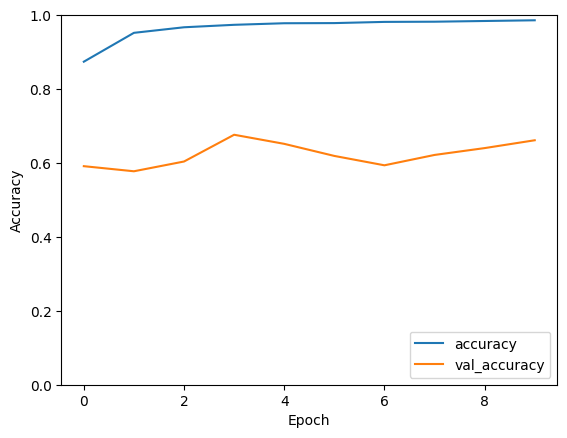

In [21]:
# Plot the feature importances
tf.keras.utils.plot_model(best_model, to_file='best_lstm_model.png', show_shapes=True, show_layer_names=True)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

update architecture

In [22]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
# update architecture
def create_model_v1(trial):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=trial.suggest_int('units_1', 32, 128), return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_1', 0.2, 0.5)))
    model.add(Bidirectional(LSTM(units=trial.suggest_int('units_2', 16, 64), return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_2', 0.2, 0.5)))
    model.add(Bidirectional(LSTM(units=trial.suggest_int('units_3', 16, 64))))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_3', 0.2, 0.5)))
    model.add(Dense(units=trial.suggest_int('dense_units', 32, 128), activation='relu'))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=trial.suggest_float('learning rate', 1e-4, 1e-2)),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [24]:
# Define the objective function for Optuna
def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),
                        epochs=50, batch_size=trial.suggest_int('batch_size', 32, 128),
                        verbose=0, callbacks=[early_stopping])

    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(y_test_encoded, y_pred)

    return accuracy

In [25]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-06-17 14:35:35,035] A new study created in memory with name: no-name-7bdf6469-3336-4405-ae06-fa38d98da262


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 14:42:55,315] Trial 0 finished with value: 0.6391925517935527 and parameters: {'units_1': 84, 'dropout_1': 0.45409559448662495, 'units_2': 29, 'dropout_2': 0.46485718098614, 'dense_units': 118, 'learning_rate': 0.007252788654604704, 'batch_size': 51}. Best is trial 0 with value: 0.6391925517935527.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 14:46:09,143] Trial 1 finished with value: 0.5973103698940364 and parameters: {'units_1': 46, 'dropout_1': 0.46430014679264203, 'units_2': 27, 'dropout_2': 0.42915411619149113, 'dense_units': 73, 'learning_rate': 0.0051390116761836505, 'batch_size': 74}. Best is trial 0 with value: 0.6391925517935527.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 14:50:22,647] Trial 2 finished with value: 0.6228087343081612 and parameters: {'units_1': 33, 'dropout_1': 0.26608844213878974, 'units_2': 52, 'dropout_2': 0.2538145320481757, 'dense_units': 47, 'learning_rate': 0.00011351206847035019, 'batch_size': 61}. Best is trial 0 with value: 0.6391925517935527.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 14:55:53,063] Trial 3 finished with value: 0.5871893085805351 and parameters: {'units_1': 90, 'dropout_1': 0.24910962443489942, 'units_2': 56, 'dropout_2': 0.3933110941615352, 'dense_units': 82, 'learning_rate': 0.00998259652407331, 'batch_size': 90}. Best is trial 0 with value: 0.6391925517935527.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 14:58:00,746] Trial 4 finished with value: 0.6319232812368943 and parameters: {'units_1': 82, 'dropout_1': 0.41750448531569495, 'units_2': 18, 'dropout_2': 0.25875467306125177, 'dense_units': 47, 'learning_rate': 0.008556733785586785, 'batch_size': 104}. Best is trial 0 with value: 0.6391925517935527.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 14:59:16,225] Trial 5 finished with value: 0.6103950568960215 and parameters: {'units_1': 64, 'dropout_1': 0.2260789054284474, 'units_2': 58, 'dropout_2': 0.48502455159636626, 'dense_units': 60, 'learning_rate': 0.003032439690360748, 'batch_size': 125}. Best is trial 0 with value: 0.6391925517935527.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:04:01,146] Trial 6 finished with value: 0.635362205384852 and parameters: {'units_1': 73, 'dropout_1': 0.2718596667212639, 'units_2': 43, 'dropout_2': 0.28180744699511856, 'dense_units': 78, 'learning_rate': 0.007225016390516823, 'batch_size': 65}. Best is trial 0 with value: 0.6391925517935527.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:05:45,962] Trial 7 finished with value: 0.6320351161685352 and parameters: {'units_1': 114, 'dropout_1': 0.4206825095935547, 'units_2': 52, 'dropout_2': 0.22826115638163222, 'dense_units': 69, 'learning_rate': 0.006571087322675916, 'batch_size': 92}. Best is trial 0 with value: 0.6391925517935527.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:17:22,801] Trial 8 finished with value: 0.63013392233064 and parameters: {'units_1': 36, 'dropout_1': 0.2290444476563253, 'units_2': 24, 'dropout_2': 0.38120628809169277, 'dense_units': 66, 'learning_rate': 0.005932560492611213, 'batch_size': 33}. Best is trial 0 with value: 0.6391925517935527.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:27:15,675] Trial 9 finished with value: 0.554421673609752 and parameters: {'units_1': 127, 'dropout_1': 0.36789037480413744, 'units_2': 45, 'dropout_2': 0.40936105769530917, 'dense_units': 81, 'learning_rate': 0.006320586581018627, 'batch_size': 66}. Best is trial 0 with value: 0.6391925517935527.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:32:47,031] Trial 10 finished with value: 0.6388011295328095 and parameters: {'units_1': 100, 'dropout_1': 0.49777777715565363, 'units_2': 33, 'dropout_2': 0.48098049892726635, 'dense_units': 123, 'learning_rate': 0.0028915150211807385, 'batch_size': 34}. Best is trial 0 with value: 0.6391925517935527.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:37:11,184] Trial 11 finished with value: 0.6864987278776525 and parameters: {'units_1': 99, 'dropout_1': 0.4996486964959063, 'units_2': 33, 'dropout_2': 0.4924249789968579, 'dense_units': 126, 'learning_rate': 0.002948393948166245, 'batch_size': 32}. Best is trial 11 with value: 0.6864987278776525.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:42:51,686] Trial 12 finished with value: 0.6013923448989292 and parameters: {'units_1': 102, 'dropout_1': 0.4913867951598609, 'units_2': 37, 'dropout_2': 0.45492051207387185, 'dense_units': 122, 'learning_rate': 0.002899699236296985, 'batch_size': 49}. Best is trial 11 with value: 0.6864987278776525.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:45:48,580] Trial 13 finished with value: 0.6103950568960215 and parameters: {'units_1': 63, 'dropout_1': 0.43208071186055885, 'units_2': 31, 'dropout_2': 0.3446814245443257, 'dense_units': 104, 'learning_rate': 0.0041392655449429844, 'batch_size': 49}. Best is trial 11 with value: 0.6864987278776525.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:48:49,413] Trial 14 finished with value: 0.581317974669388 and parameters: {'units_1': 97, 'dropout_1': 0.35084181889611565, 'units_2': 17, 'dropout_2': 0.33923059965092395, 'dense_units': 109, 'learning_rate': 0.0007303400518638564, 'batch_size': 47}. Best is trial 11 with value: 0.6864987278776525.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:53:55,995] Trial 15 finished with value: 0.6280370173623732 and parameters: {'units_1': 116, 'dropout_1': 0.45997898117708463, 'units_2': 38, 'dropout_2': 0.494477764779362, 'dense_units': 98, 'learning_rate': 0.0078016979143983815, 'batch_size': 42}. Best is trial 11 with value: 0.6864987278776525.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:56:53,031] Trial 16 finished with value: 0.6424916822769592 and parameters: {'units_1': 81, 'dropout_1': 0.38301899686797514, 'units_2': 23, 'dropout_2': 0.4442990357954746, 'dense_units': 127, 'learning_rate': 0.001290134152674348, 'batch_size': 57}. Best is trial 11 with value: 0.6864987278776525.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 15:59:29,453] Trial 17 finished with value: 0.7366846534515056 and parameters: {'units_1': 71, 'dropout_1': 0.31454786070811924, 'units_2': 22, 'dropout_2': 0.43675530213986086, 'dense_units': 92, 'learning_rate': 0.0016309458618835575, 'batch_size': 57}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:01:25,484] Trial 18 finished with value: 0.5912712835854279 and parameters: {'units_1': 70, 'dropout_1': 0.3100418640484436, 'units_2': 64, 'dropout_2': 0.3200786405624914, 'dense_units': 92, 'learning_rate': 0.0017160010783423764, 'batch_size': 77}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:06:39,731] Trial 19 finished with value: 0.6594067156876451 and parameters: {'units_1': 54, 'dropout_1': 0.32090387236486784, 'units_2': 21, 'dropout_2': 0.37425266216164665, 'dense_units': 90, 'learning_rate': 0.0039628722676602265, 'batch_size': 40}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:11:43,124] Trial 20 finished with value: 0.596136103111807 and parameters: {'units_1': 108, 'dropout_1': 0.30898614521378087, 'units_2': 34, 'dropout_2': 0.42407366621022596, 'dense_units': 111, 'learning_rate': 0.0022625720958741494, 'batch_size': 32}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:15:41,655] Trial 21 finished with value: 0.5927810551625801 and parameters: {'units_1': 53, 'dropout_1': 0.31524310174104236, 'units_2': 22, 'dropout_2': 0.37408242726047297, 'dense_units': 93, 'learning_rate': 0.004135200446245557, 'batch_size': 41}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:20:44,176] Trial 22 finished with value: 0.6468532446109543 and parameters: {'units_1': 54, 'dropout_1': 0.33533031595725404, 'units_2': 20, 'dropout_2': 0.3060664379132183, 'dense_units': 87, 'learning_rate': 0.0039889711777923754, 'batch_size': 41}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:24:05,616] Trial 23 finished with value: 0.6000223669863282 and parameters: {'units_1': 44, 'dropout_1': 0.2958196416586501, 'units_2': 27, 'dropout_2': 0.36771880205169916, 'dense_units': 35, 'learning_rate': 0.004764520230324086, 'batch_size': 56}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:27:45,664] Trial 24 finished with value: 0.6525288673917298 and parameters: {'units_1': 71, 'dropout_1': 0.3907085927570045, 'units_2': 25, 'dropout_2': 0.4173463418079865, 'dense_units': 104, 'learning_rate': 0.0020831185744656193, 'batch_size': 39}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:29:50,392] Trial 25 finished with value: 0.7066290155730143 and parameters: {'units_1': 59, 'dropout_1': 0.20213263440906776, 'units_2': 16, 'dropout_2': 0.46025220248107046, 'dense_units': 113, 'learning_rate': 0.0034734145223804715, 'batch_size': 70}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:32:15,180] Trial 26 finished with value: 0.6365923896329019 and parameters: {'units_1': 91, 'dropout_1': 0.20856415833525974, 'units_2': 16, 'dropout_2': 0.46412462394391457, 'dense_units': 115, 'learning_rate': 0.0033650291771538305, 'batch_size': 71}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:33:59,825] Trial 27 finished with value: 0.6911678362736601 and parameters: {'units_1': 59, 'dropout_1': 0.27343451390489815, 'units_2': 42, 'dropout_2': 0.49694924256866735, 'dense_units': 101, 'learning_rate': 0.0010634550426381149, 'batch_size': 85}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:35:40,520] Trial 28 finished with value: 0.6195934800234854 and parameters: {'units_1': 61, 'dropout_1': 0.2045091532578304, 'units_2': 45, 'dropout_2': 0.4414296200752369, 'dense_units': 104, 'learning_rate': 0.0009002044763029961, 'batch_size': 88}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:37:28,576] Trial 29 finished with value: 0.6492017781754131 and parameters: {'units_1': 75, 'dropout_1': 0.2822332236620048, 'units_2': 42, 'dropout_2': 0.47086600593033034, 'dense_units': 98, 'learning_rate': 0.0001938967399792216, 'batch_size': 82}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:38:57,143] Trial 30 finished with value: 0.635865462577236 and parameters: {'units_1': 48, 'dropout_1': 0.24631487705101773, 'units_2': 48, 'dropout_2': 0.40292974297661444, 'dense_units': 115, 'learning_rate': 0.0016871434715614137, 'batch_size': 100}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:40:59,095] Trial 31 finished with value: 0.6097520060390863 and parameters: {'units_1': 66, 'dropout_1': 0.3436900662678587, 'units_2': 31, 'dropout_2': 0.4932837644399515, 'dense_units': 128, 'learning_rate': 0.0019798919843452747, 'batch_size': 84}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:43:07,582] Trial 32 finished with value: 0.6433024855313557 and parameters: {'units_1': 89, 'dropout_1': 0.25557655755133246, 'units_2': 36, 'dropout_2': 0.46203385849626577, 'dense_units': 120, 'learning_rate': 0.002570665280715261, 'batch_size': 70}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:46:04,205] Trial 33 finished with value: 0.6152039589565801 and parameters: {'units_1': 59, 'dropout_1': 0.28559473647724565, 'units_2': 27, 'dropout_2': 0.49831393241111305, 'dense_units': 99, 'learning_rate': 0.0011905346110685213, 'batch_size': 55}. Best is trial 17 with value: 0.7366846534515056.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:47:34,813] Trial 34 finished with value: 0.7446249335980093 and parameters: {'units_1': 76, 'dropout_1': 0.3637910310386666, 'units_2': 30, 'dropout_2': 0.4442254127014773, 'dense_units': 111, 'learning_rate': 0.004947064826778765, 'batch_size': 103}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:50:01,545] Trial 35 finished with value: 0.6387452120669891 and parameters: {'units_1': 78, 'dropout_1': 0.37662003084641815, 'units_2': 18, 'dropout_2': 0.4341600628816817, 'dense_units': 109, 'learning_rate': 0.005659210083926656, 'batch_size': 111}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:51:34,210] Trial 36 finished with value: 0.6743087203287947 and parameters: {'units_1': 68, 'dropout_1': 0.3558867185042963, 'units_2': 29, 'dropout_2': 0.44912136678351544, 'dense_units': 86, 'learning_rate': 0.005312628103035676, 'batch_size': 97}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:52:59,420] Trial 37 finished with value: 0.6903849917521738 and parameters: {'units_1': 40, 'dropout_1': 0.40209147756010494, 'units_2': 40, 'dropout_2': 0.4729901871791008, 'dense_units': 115, 'learning_rate': 0.004713025657754099, 'batch_size': 106}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:55:06,716] Trial 38 finished with value: 0.5888109150893281 and parameters: {'units_1': 49, 'dropout_1': 0.23329074275859857, 'units_2': 19, 'dropout_2': 0.3936187986558904, 'dense_units': 96, 'learning_rate': 0.0035757156698123143, 'batch_size': 125}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:56:27,256] Trial 39 finished with value: 0.6059216596303856 and parameters: {'units_1': 86, 'dropout_1': 0.27641138840341395, 'units_2': 49, 'dropout_2': 0.428976384234318, 'dense_units': 77, 'learning_rate': 0.0005419811740050827, 'batch_size': 117}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 16:59:06,513] Trial 40 finished with value: 0.6320630749014454 and parameters: {'units_1': 58, 'dropout_1': 0.32761041502587795, 'units_2': 25, 'dropout_2': 0.4786032482241139, 'dense_units': 106, 'learning_rate': 0.0013682109358734307, 'batch_size': 63}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 17:01:06,070] Trial 41 finished with value: 0.6186988005703582 and parameters: {'units_1': 42, 'dropout_1': 0.41074903787197153, 'units_2': 40, 'dropout_2': 0.4724503247975, 'dense_units': 115, 'learning_rate': 0.004926044846342335, 'batch_size': 109}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 17:02:24,774] Trial 42 finished with value: 0.6574775631168396 and parameters: {'units_1': 39, 'dropout_1': 0.3997985259741475, 'units_2': 40, 'dropout_2': 0.4576083275124185, 'dense_units': 117, 'learning_rate': 0.005298416819591832, 'batch_size': 116}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 17:04:07,794] Trial 43 finished with value: 0.7050353677971314 and parameters: {'units_1': 76, 'dropout_1': 0.2952722183184059, 'units_2': 55, 'dropout_2': 0.4397687979031949, 'dense_units': 112, 'learning_rate': 0.009930971584773754, 'batch_size': 96}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 17:06:16,680] Trial 44 finished with value: 0.6062851231582185 and parameters: {'units_1': 79, 'dropout_1': 0.2964093926603605, 'units_2': 57, 'dropout_2': 0.4054053808771309, 'dense_units': 100, 'learning_rate': 0.009402687208457609, 'batch_size': 95}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 17:08:01,301] Trial 45 finished with value: 0.537227052869964 and parameters: {'units_1': 73, 'dropout_1': 0.25946200896732796, 'units_2': 61, 'dropout_2': 0.4384923585147212, 'dense_units': 109, 'learning_rate': 0.007042305220195945, 'batch_size': 87}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 17:13:15,823] Trial 46 finished with value: 0.5400508848938966 and parameters: {'units_1': 65, 'dropout_1': 0.36646836061464616, 'units_2': 54, 'dropout_2': 0.42416364171760473, 'dense_units': 56, 'learning_rate': 0.007991512934789615, 'batch_size': 76}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 17:19:11,418] Trial 47 finished with value: 0.6232001565689043 and parameters: {'units_1': 84, 'dropout_1': 0.24136780573562702, 'units_2': 50, 'dropout_2': 0.48309145287145205, 'dense_units': 111, 'learning_rate': 0.00950037674751129, 'batch_size': 92}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 17:20:42,297] Trial 48 finished with value: 0.6704504151871837 and parameters: {'units_1': 75, 'dropout_1': 0.21381761634311874, 'units_2': 16, 'dropout_2': 0.23580508515283152, 'dense_units': 122, 'learning_rate': 0.006403896022390761, 'batch_size': 100}. Best is trial 34 with value: 0.7446249335980093.


1118/1118 [==============================] - 4s 3ms/step


[I 2024-06-17 17:25:25,829] Trial 49 finished with value: 0.6876170771940615 and parameters: {'units_1': 68, 'dropout_1': 0.22336805798332665, 'units_2': 54, 'dropout_2': 0.4530250851136151, 'dense_units': 102, 'learning_rate': 0.0033575640654797483, 'batch_size': 69}. Best is trial 34 with value: 0.7446249335980093.


In [26]:
# Print best hyperparameters
print('Best hyperparameters:', study.best_params)

# Visualize the optimization history
optuna.visualization.plot_optimization_history(study)
plt.show()

# Visualize the hyperparameter importance
optuna.visualization.plot_param_importances(study)
plt.show()

Best hyperparameters: {'units_1': 76, 'dropout_1': 0.3637910310386666, 'units_2': 30, 'dropout_2': 0.4442254127014773, 'dense_units': 111, 'learning_rate': 0.004947064826778765, 'batch_size': 103}


In [29]:
# Train the best model using the best hyperparameters
best_trial = study.best_trial
best_model = create_model(best_trial)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
best_model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),
               epochs=50, batch_size=best_trial.params['batch_size'],
               verbose=1, callbacks=[early_stopping])

Epoch 1/50
1719/1719 [==============================] - 19s 9ms/step - loss: 0.3681 - accuracy: 0.8447 - val_loss: 3.0726 - val_accuracy: 0.6079
Epoch 2/50
1719/1719 [==============================] - 15s 9ms/step - loss: 0.1287 - accuracy: 0.9517 - val_loss: 3.0394 - val_accuracy: 0.6269
Epoch 3/50
1719/1719 [==============================] - 15s 9ms/step - loss: 0.1016 - accuracy: 0.9638 - val_loss: 2.8200 - val_accuracy: 0.5954
Epoch 4/50
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0917 - accuracy: 0.9681 - val_loss: 2.7749 - val_accuracy: 0.6358
Epoch 5/50
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0864 - accuracy: 0.9697 - val_loss: 2.9417 - val_accuracy: 0.6173
Epoch 6/50
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0726 - accuracy: 0.9750 - val_loss: 2.5148 - val_accuracy: 0.6238
Epoch 7/50
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0689 - accuracy: 0.9758 - val_loss: 4.5894 - val_ac

1118/1118 [==============================] - 5s 4ms/step
Accuracy of the best model: 0.623787289960019
Classification Report:
              precision    recall  f1-score   support

          FB       0.95      0.87      0.91      5996
       Insta       0.50      1.00      0.66      5951
         Red       0.00      0.00      0.00      5955
      Reddit       0.52      0.94      0.67      5955
      TikTok       0.62      0.13      0.21      5955
           X       0.88      0.80      0.84      5955

    accuracy                           0.62     35767
   macro avg       0.58      0.62      0.55     35767
weighted avg       0.58      0.62      0.55     35767



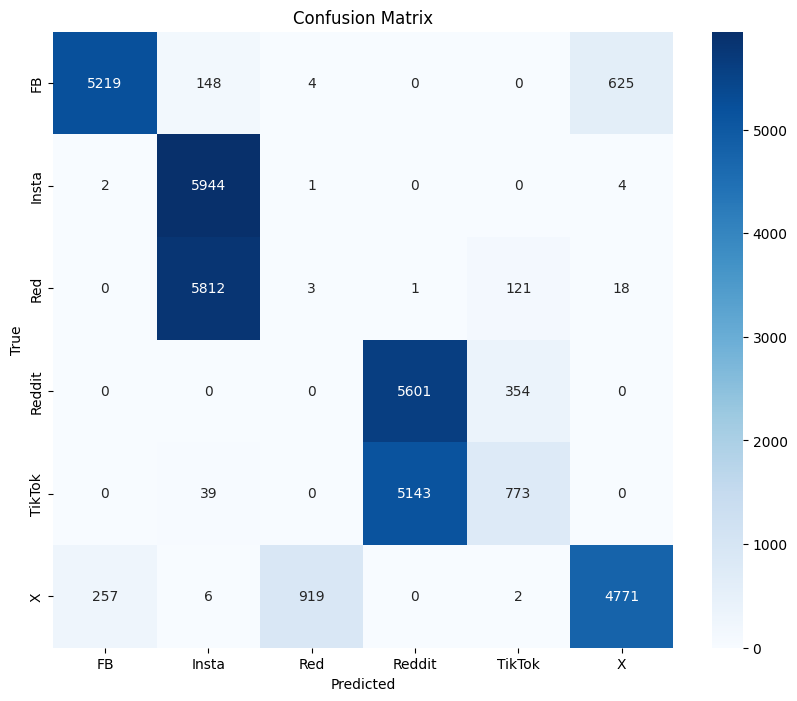

In [30]:
# Evaluate the best model
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy of the best model: {accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [31]:
from keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Early stopping callback with higher patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with the best hyperparameters found
best_model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),
               epochs=50, batch_size=best_trial.params['batch_size'],
               verbose=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/50
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0770 - accuracy: 0.9740 - val_loss: 2.7718 - val_accuracy: 0.6194 - lr: 0.0049
Epoch 2/50
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0657 - accuracy: 0.9773 - val_loss: 3.3950 - val_accuracy: 0.6385 - lr: 0.0049
Epoch 3/50
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0663 - accuracy: 0.9774 - val_loss: 2.9731 - val_accuracy: 0.6452 - lr: 0.0049
Epoch 4/50
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0594 - accuracy: 0.9794 - val_loss: 2.8438 - val_accuracy: 0.6182 - lr: 0.0049
Epoch 5/50
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0316 - accuracy: 0.9888 - val_loss: 3.3946 - val_accuracy: 0.6295 - lr: 0.0010
Epoch 6/50
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0267 - accuracy: 0.9903 - val_loss: 3.3605 - val_accuracy: 0.6421 - lr: 0.0010
Epoch 7/50
1719/1719 [==============================

1118/1118 [==============================] - 4s 4ms/step
Accuracy of the best model: 0.6193977688931137
Classification Report:
              precision    recall  f1-score   support

          FB       0.99      0.85      0.92      5996
       Insta       0.49      1.00      0.66      5951
         Red       0.00      0.00      0.00      5955
      Reddit       0.61      0.99      0.75      5955
      TikTok       0.97      0.35      0.52      5955
           X       0.86      0.52      0.65      5955

    accuracy                           0.62     35767
   macro avg       0.65      0.62      0.58     35767
weighted avg       0.65      0.62      0.58     35767



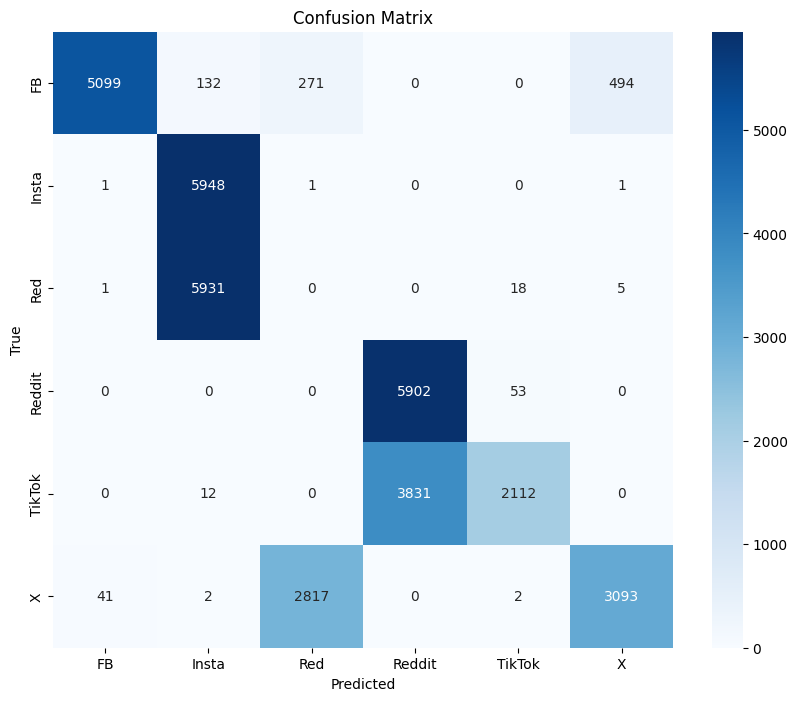

In [32]:
# Evaluate the best model
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy of the best model: {accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

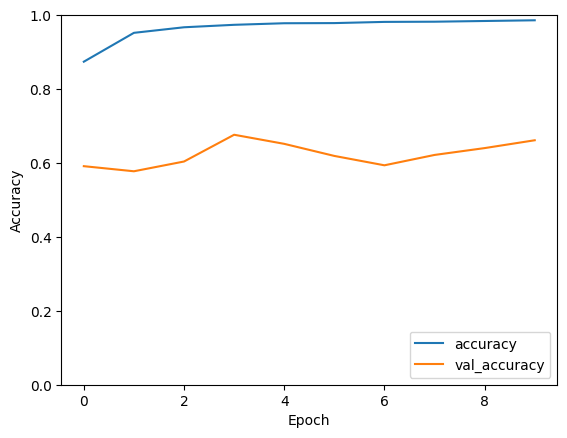

In [33]:
# Plot the feature importances
tf.keras.utils.plot_model(best_model, to_file='best_lstm_model.png', show_shapes=True, show_layer_names=True)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()